# Data Curation Notebook C - Gene Set Annotation

This notebook:...

- Processing of annotation data
- Biological features
- Analysis of gene sets
- analysis of overlap data

**Inputs:**
* Supplemental Table 2 (`'outputs/STable2.tsv'`)
* gnomAD constraint metrics (`gnomad.v4.1.constraint_metrics.tsv.gz`)
* Selective constraint (`'s_het_estimates.genebayes.tsv`)
* mRNA Expression (`gtex_median_processed_1.tsv.gz`)
* GO Annotations (`gene2go.gz`)
* Gene length & protein coding annotations (`Ensembl_Feb14_2025.txt.gz`)


**Figures generated:**
- Figure 1C
- Figure 1F

**Tables generated:**
* Supplemental Table 1. Input Information


### Set Up

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from scipy.stats import wilcoxon, mannwhitneyu
from statsmodels.stats.multitest import fdrcorrection
import sys
from neteval.gene_mapper import *

In [2]:
cwd = os.getcwd()
datadir = os.path.join(cwd, '..')

In [4]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
import matplotlib.font_manager as fm
arial_font_path = os.path.join(datadir, 'Reference_Data', 'Arial.TTF')
fm.fontManager.addfont(arial_font_path)
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'

In [5]:
blue='#6ec1e0'
green='#5fad56'
shared='#af3800'
binary='#00606f'

In [6]:
#datadir='/cellar/users/snwright/Data/RareCommon/'
#outdir='/cellar/users/snwright/Data/Transfer/RVC/'
#figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/FigureOverlap/'

In [7]:
#basedir='/cellar/users/snwright/Data/RareCommon'
#annot_dir = os.path.join(basedir, 'Annotations')
#input_dir = os.path.join(basedir, 'inputs/March_2025')
#keydir= os.path.join(basedir, 'outputs/key_files')
#colocdir = os.path.join(basedir, 'outputs/netcoloc/March_2025')
#figdir = '/cellar/users/snwright/Data/Transfer/RVC/figures/Bio_features'

In [6]:
import re
def map_trait_code(code):
    efo = next((match.group() for match in re.finditer(r'EFO_\d+', code)), None)
    if efo is not None:
        return efo
    mondo = next((match.group() for match in re.finditer(r'MONDO_\d+', code)), None)
    if mondo is not None:
        return mondo
    hp = next((match.group() for match in re.finditer(r'HP_\d+', code)), None)
    if hp is not None:
        return hp
    go = next((match.group() for match in re.finditer(r'GO_\d+', code)), None)
    if go is not None:
        return go
    oba = next((match.group() for match in re.finditer(r'OBA_\d+', code)), None)
    if oba is not None:
        return oba
    return None

### Load Data

In [7]:
def get_trait_pair(df):
    df['trait_pair'] = df['Rare Study'].astype(int).astype(str) + '_' + df['EFO'] +'_' +df['Common Study'] +'_'+ df['EFO']
    return df

In [269]:
overlap_df = pd.read_csv(os.path.join(datadir, 'outputs/STable2.tsv'), sep='\t', usecols=['EFO', 'Trait', 'Common Study',
            'Rare Study', 'Analysis Set', 'nCommon', 'nRare', 'nShared', 'pShared'])
overlap_df = get_trait_pair(overlap_df)
over_df = overlap_df[overlap_df['Analysis Set']=='Initial'].copy()
over_df['logp'] = -1 * np.log10(over_df['pShared'] + 1e-250)

In [240]:
pairs = over_df.trait_pair.values
all_pairs = overlap_df.trait_pair.values

## Annotation Data Processing

### Mutational Constraint

In [10]:
def prioritize_gene_duplicates(df, gene, score_cols):
    """Where there are multiple distinct entries for a gene, we first prioritize those representing canonical transcripts. 
    If there are multiple or no canonical transcripts we next prioritize MANE Select transcripts. Where these filters are 
    unable to produce a single gene entry, we prioritize the entry assigned an NCBI Gene ID. """
    # sort such that NCBI Gene IDs will be first
    gene_df = df[df.gene==gene].sort_values('gene_id')
    if len(gene_df) == 0:
        return None
    # if there is only one entry, take this entry
    if len(gene_df)==1:
        return gene_df.index.values[0]
    # if there are multiple entries
    else:
        # if all entries have the same scores, take the first ID (will be NCBI Gene ID if available)
        if len(gene_df.drop_duplicates(subset=score_cols)) == 1:
            # results are all the same anyway. Return the entry with entrez id
            return gene_df.index.values[0]
        
        # Otherwise, we need to prioritize amongst the results
        else:
            # is there at least one canonical transcript
            if len(gene_df[(gene_df.canonical)]) >= 1:
                gene_df = gene_df[gene_df.canonical]
                
            # is there at least one mane select transcript
            if len(gene_df[(gene_df.mane_select)]) >= 1:
                gene_df = gene_df[gene_df.mane_select]
                
            # at this point all entries should have the same values for canonical and mane_select
            # check if these prioritizations have left us with just one entry
            if len(gene_df) == 1:
                return gene_df.index.values[0]
            
            # check if there are any duplicates
            dups = gene_df.duplicated(subset=score_cols, keep='first')
            if sum(dups) > 0:
                # take the duplicated values as the correct ones.
                return gene_df[~dups].index.values[0]
            
            # any dfs making it here have different scores, but same transcript designations
            return gene_df.index.values[0]

#### LOEUF & Expected LoF

lof.oe_ci.upper: LOEUF: upper bound of 90% confidence interval for o/e ratio for high confidence pLoF variants (lower values indicate more constrained)

In [11]:
pli_df = pd.read_csv(os.path.join(datadir, 'Reference_Data', 'gnomad.v4.1.constraint_metrics.tsv.gz'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'lof.z_score', 'lof.pLI', 'lof_hc_lc.pLI','lof.oe_ci.upper',
                            'lof.exp', 'cds_length'])
# exclude non-canonical transcripts
print(pli_df.gene.nunique())

18203


In [12]:
out = []
for gene in tqdm(pli_df.gene.unique()):
    out.append(prioritize_gene_duplicates(pli_df, gene, score_cols=['lof.pLI', 'lof.z_score', 'lof_hc_lc.pLI', 'lof.oe_ci.upper']))

100%|██████████| 18204/18204 [04:32<00:00, 66.90it/s]


In [125]:
gene_pli = pli_df.iloc[out[:-1], :]

Map identifiers to NCBI Gene IDs

In [126]:
print('# Ensembl IDs:', len(gene_pli[~gene_pli.gene_id.str.isnumeric()]))

# Ensembl IDs: 740


In [127]:
gene_map = pli_df.loc[pli_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_pli[~gene_pli.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_pli = pd.concat([gene_pli[gene_pli.gene_id.str.isnumeric()], gene_map])#.drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [128]:
missing_pli = gene_pli[gene_pli.gene_id.isna()]
missing_sym = gene_pli[gene_pli.gene_id.isna()]['gene'].values

In [129]:
updated_symb, missing = update_nodes(missing_sym, 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symb.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))
missing_pli = missing_pli.assign(gene_id = missing_pli.gene.apply(lambda x: converted_ids[updated_symb[x]]))

Initial Ids 110
Checking approved symbols
Response received
Check names 10
Previous Ids 8
Checking previous symbols
Missing: 0
Missing: 0


In [18]:
gene_pli = pd.concat([gene_pli, missing_pli ])
gene_pli = gene_pli.drop_duplicates(subset=['gene_id', 'lof.oe_ci.upper'])
print(len(gene_pli), gene_pli.gene_id.nunique())

18237 18200


In [130]:
gene_pli = gene_pli.drop(columns=['gene_idx', 'canonical', 'mane_select'])

In [131]:
gene_pli = gene_pli.rename(columns={'gene':'Symbol', 'gene_id':'Entrez', 'lof.oe_ci.upper':'LOEUF'})

In [132]:
gene_pli.loc[:, ('Entrez', 'LOEUF', 'lof.exp')].to_csv(os.path.join(datadir, 'outputs', 'Gene_pLI.txt'), index=False, sep='\t')

#### Synonymous Intolerance

-syn.z_score: Z-score for synonymous variants in transcript. Higher (more positive) Z scores indicate that the transcript is more intolerant of variation (more constrained).

In [25]:
mis_df = pd.read_csv(os.path.join(datadir, 'Reference_Data', 'gnomad.v4.1.constraint_metrics.tsv.gz'), sep='\t',
                    usecols=['gene', 'gene_id', 'canonical','mane_select', 'mis.z_score', 'syn.z_score'])
# exclude non-canonical transcripts
print(mis_df.gene.nunique())

18203


In [26]:
out = []
for gene in tqdm(mis_df.gene.unique()):
    out.append(prioritize_gene_duplicates(mis_df, gene, score_cols=['mis.z_score', 'syn.z_score']))

100%|██████████| 18204/18204 [04:24<00:00, 68.76it/s]


In [27]:
gene_mis = mis_df.iloc[out[:-1], :]
len(gene_mis)

18203

Map indentifiers to NCBI Gene IDs

In [28]:
# replace with NCBI IDs as needed
print('# Ensembl IDs:', len(gene_mis[~gene_mis.gene_id.str.isnumeric()]))

# Ensembl IDs: 740


In [29]:
gene_map = mis_df.loc[mis_df.gene_id.str.isnumeric(), ('gene', 'gene_id')].merge(gene_mis[~gene_mis.gene_id.str.isnumeric()], on='gene', suffixes=('', 'x'), how='right').drop_duplicates(subset=['gene'])
gene_mis = pd.concat([gene_mis[gene_mis.gene_id.str.isnumeric()], gene_map]).drop(columns=['gene_idx', 'canonical', 'mane_select'])

,gene,gene_id,mis.z_score,syn.z_score
0,A1BG,1,-0.86092,-0.635490
8,A1CF,29974,1.23730,0.017838
23,A2M,2,2.75870,1.836200
33,A2ML1,144568,1.65710,0.951210
45,A3GALT2,127550,-4.07990,-3.997000


In [31]:
gene_mis = gene_mis.rename(columns={'gene_id': 'Entrez'})

In [32]:
gene_mis.loc[:, ('Entrez', 'syn.z_score')].to_csv(os.path.join(datadir,'outputs', 'Gene_MisSyn.txt'), index=False, sep='\t')

#### s_het

Use the mean of the posterior distribution

In [133]:
shet_raw = pd.read_csv(os.path.join(datadir, 'Reference_Data', 's_het_estimates.genebayes.tsv'), 
                       sep='\t')

In [35]:
# convert ensg to NCBI gene ids.
updated_ensg, missing = update_nodes(shet_raw.ensg.unique(), 'Ensembl')
print('Missing:', len(missing))

Query batch 0 - 1000
Query batch 1000 - 2000
Query batch 2000 - 3000
Query batch 3000 - 4000
Query batch 4000 - 5000
Query batch 5000 - 6000
Query batch 6000 - 7000
Query batch 7000 - 8000
Query batch 8000 - 9000
Query batch 9000 - 10000
Query batch 10000 - 11000
Query batch 11000 - 12000
Query batch 12000 - 13000
Query batch 13000 - 14000
Query batch 14000 - 15000
Query batch 15000 - 16000
Query batch 16000 - 17000
Query batch 17000 - 18000
Query batch 18000 - 19000
Query batch 19000 - 19071
Missing: 0


In [36]:
converted_ids, missing= convert_node_ids(list(updated_ensg.values()), 'Ensembl', 'Entrez') 
print('Missing:', len(missing))

Missing: 439


Exclude the missing genes

In [37]:
gene_map = {x: converted_ids[y] for x,y in updated_ensg.items() if y in converted_ids}
shet_df = shet_raw[shet_raw.ensg.isin(gene_map.keys())]
shet_df = shet_df.assign(Entrez = shet_raw.ensg.map(gene_map))

In [38]:
# Check for duplicates
sum(shet_df.Entrez.value_counts() > 1)

0

In [39]:
shet_df['log_post_mean'] = shet_df.post_mean.apply(lambda x: -1 * np.log10(x))

In [40]:
# extract the mean of the posterior distribution (post_mean) and save
shet_df.loc[:, ['Entrez', 'post_mean', 'log_post_mean']].to_csv(os.path.join(datadir, 'outputs', 'Gene_sHet.txt'), sep='\t', 
                                              index=False)

### mRNA Expression

- Average expression
- Number of expressed tissues

In [42]:
rna_raw = pd.read_csv(os.path.join(datadir, 'Reference_Data', 'gtex_median_processed_1.tsv.gz'), sep='\t')
rna_df = rna_raw[~rna_raw.Entrez.isna()].drop(columns=['Ensembl_ID', 'Symbol']).set_index('Entrez')

In [43]:
rna_metrics = pd.DataFrame({'Mean_mRNA':rna_df.mean(axis=1), 'n_Expressed':(rna_df > 1).sum(axis=1)}).reset_index()

In [44]:
rna_metrics = rna_metrics.sort_values(by='Mean_mRNA', ascending=False).drop_duplicates(subset='Entrez', keep='first')

In [45]:
rna_metrics.to_csv(os.path.join(datadir, 'outputs', 'Gene_mRNA.txt'), sep='\t', index=False)

### GO Annotations

In [46]:
go_df = pd.read_csv(os.path.join(datadir, 'Reference_Data', 'gene2go.gz'), sep='\t')
go_df = go_df[go_df['#tax_id']==9606].drop(columns=['#tax_id'])

In [47]:
# remove negating qualifiers
exclude_qualifiers = [x for x in go_df.Qualifier.unique() if 'NOT' in x]
go_df = go_df[~go_df.Qualifier.isin(exclude_qualifiers)]

In [48]:
go_counts = go_df.groupby(['GeneID', 'Category']).GO_ID.nunique().reset_index()
go_counts = go_counts.pivot_table(index='GeneID', columns=['Category'], values='GO_ID', fill_value=0).reset_index()

Category,GeneID,Component,Function,Process
0,1,9.0,1.0,1.0
1,2,6.0,14.0,11.0
2,9,1.0,1.0,1.0
3,10,1.0,2.0,1.0
4,12,9.0,3.0,5.0


In [49]:
go_counts.columns = ['Entrez', 'n_GO_CC', 'n_GO_MF', 'n_GO_BP']
go_counts['n_GO']=go_counts['n_GO_CC'] + go_counts['n_GO_MF'] + go_counts['n_GO_BP']

In [50]:
go_counts.to_csv(os.path.join(datadir, 'outputs', 'Gene_GO.txt'), sep='\t', index=False)

### Gene length

In [51]:
length_df = pd.read_csv(os.path.join(datadir, 'Reference_Data','Ensembl_Feb14_2025.txt.gz'), sep='\t', low_memory=False,
                       usecols=['Gene stable ID', 'Gene start (bp)', 'Gene end (bp)', 'Chromosome/scaffold name',
                               'NCBI gene (formerly Entrezgene) ID', 'HGNC symbol',
                               'Transcript length (including UTRs and CDS)'],
                       )

,Gene stable ID,Gene start (bp),Gene end (bp),Chromosome/scaffold name,Transcript length (including UTRs and CDS),NCBI gene (formerly Entrezgene) ID,HGNC symbol
0,ENSG00000210049,577,647,MT,71,NaN,MT-TF
1,ENSG00000211459,648,1601,MT,954,NaN,MT-RNR1
2,ENSG00000210077,1602,1670,MT,69,NaN,MT-TV
3,ENSG00000210082,1671,3229,MT,1559,NaN,MT-RNR2
4,ENSG00000209082,3230,3304,MT,75,NaN,MT-TL1


In [52]:
length_df = length_df.rename(columns = {'Gene stable ID':'Ensembl', 'Gene start (bp)':'Start',
                                        'Gene end (bp)': 'End', 'Chromosome/scaffold name':'Chrom',
                                        'NCBI gene (formerly Entrezgene) ID': 'Entrez', 'HGNC symbol':'Symbol',
                                       'Transcript length (including UTRs and CDS)': 'CDS_length'})
length_df = length_df.dropna(subset=['Start', 'End', 'Entrez']).drop_duplicates()
length_df = length_df[length_df.Chrom.isin([str(x) for x in range(1, 23)] + ['X', 'Y'])]
length_df = length_df[~length_df.Symbol.isna()]
length_df['GeneSize'] = length_df['End'] - length_df['Start']

Map indentifiers to NCBI Gene IDs

In [53]:
updated_symbols, missing = update_nodes(length_df.Symbol.unique(), 'Symbol')
print('Missing:', len(missing))
converted_ids, missing= convert_node_ids(list(updated_symbols.values()), 'Symbol', 'Entrez') 
print('Missing:', len(missing))

Initial Ids 25034
Checking approved symbols
Response received
Check names 95
Previous Ids 53
Checking previous symbols
Alias Ids 2
Searching aliases
Missing: 2
Searching Entrez
Missing: 0


In [54]:
gene_map = {x: converted_ids[y] for x,y in updated_symbols.items()}
length_df = length_df.assign(Entrez = length_df.Symbol.map(gene_map))
# remove duplicated gene lengths
length_df = length_df.drop_duplicates(subset=['Entrez', 'GeneSize'])

In [55]:
print('Genes with conflicting entries:',  length_df[length_df.Entrez.duplicated(keep=False)].Entrez.nunique())
# Remove genes with conflicting entries
length_df = length_df[~length_df.Entrez.isin(length_df[length_df.Entrez.duplicated(keep=False)].Entrez.values)]
print('Final size:', len(length_df))

Genes with conflicting entries: 21
Final size: 25003


In [56]:
length_df.sort_values('Entrez').loc[:, ('Entrez','Chrom', 'Start', 'End', 'GeneSize', 'CDS_length')].to_csv(os.path.join(datadir, 'outputs', 'Gene_length.txt'), sep='\t', index=False)

## Collate Annotations

In [57]:
files = { 'MisSyn': 'Gene_MisSyn.txt',  'pli': 'Gene_pLI.txt',
    'Length': 'Gene_length.txt',
    'GO': 'Gene_GO.txt' , 'sHet': 'Gene_sHet.txt',
    'mrna':'Gene_mRNA.txt', 'n_mrna':'Gene_mRNA.txt',
         'CDS': 'Gene_PhyloP.txt',
         'lof': 'Gene_pLI.txt',
         'phy': 'Gene_PhyloP.txt'
}  

In [58]:
missing_val = {
 'GO': 0,
}

usecols = {
 'MisSyn': 'syn.z_score',
 'pli': 'LOEUF',
 'Length': 'GeneSize',
 'GO': 'n_GO',
 'mrna': 'Mean_mRNA', 
 'n_mrna': 'n_Expressed',
'sHet':'post_mean',
'CDS':'CDS_Length',
'lof':'lof.exp',
'phy':'PhyloP_median'}

labels = {
 'MisSyn': 'Synonymous intolerance',
 'pli': 'Med. LOEUF',
 'Length': 'Med. Gene Size',
 'GO': 'Med. GO Terms',
 'mrna': 'mRNA Exp.', 
 'n_mrna': 'Med. Exp. Tissues',
'sHet': 'Med. Selective Constraint (shet)',
'CDS':'Med. CDS Size',
'lof': 'Med. Expected LOF',
'phy': 'Med. PhyloP'}

In [59]:
annot_dfs = {}
for met, file in files.items():
    annot_dfs[met] = pd.read_csv(os.path.join(datadir, 'outputs', file), sep='\t', index_col=0, usecols=['Entrez']+[usecols[met]]).dropna()
    annot_dfs[met] = annot_dfs[met][~annot_dfs[met].index.isna()]
    annot_dfs[met].index = annot_dfs[met].index.astype(int)
    print(met, annot_dfs[met].shape)

MisSyn (18075, 1)
pli (17954, 1)
Length (25003, 1)
GO (20739, 1)
sHet (18633, 1)
mrna (34812, 1)
n_mrna (34812, 1)
CDS (19827, 1)
lof (17954, 1)
phy (19827, 1)


In [60]:
bio_df = annot_dfs['MisSyn']
for met, df in annot_dfs.items():
    if met != 'MisSyn':
        bio_df = bio_df.join(annot_dfs[met], how='outer')
bio_df = bio_df.dropna(thresh=2)
#bio_df = bio_df.fillna({usecols[k]:missing_val[k] for k in missing_val})
bio_df = bio_df.rename(columns={usecols[k]:k for k in usecols})

In [61]:
bio_df.to_csv(os.path.join(datadir, 'outputs', 'Features_bio_gene.txt'), sep='\t')

## Gene Set Annotations

In [135]:
r_traitlist = set([x.split('_GCST')[0] for x in all_pairs])
c_traitlist = set(['GCST'+x.split('_GCST')[-1] for x in all_pairs])
print(len(r_traitlist), len(c_traitlist))

536 947


In [ ]:
def get_trait_pair(df, rcol='Rare Study', ccol='Common Study', efocol='EFO'):
    df['trait_pair'] = df[rcol].astype(int).astype(str) + '_' + df[efocol] +'_' +df[ccol] +'_'+ df[efocol]
    return df

Get the trait information from Supplemental Table 1

In [198]:
st1 = pd.read_csv(os.path.join(datadir, 'outputs', 'STable1.tsv'), sep='\t', usecols=['Mapped Trait', 'Mapped EFO', 
        'Study Identifier', 'Variant Type',
        'Trait Type', 'Biological Domain', 'Set', 'Reported Trait',
        'Trait Cosine Similarity', 'Population Cohort',
        'Population Sample Size', 'PUBMED ID', 'Gene Count', 'Gene List'])
st1 = st1.assign(StudyTrait = st1['Study Identifier'].astype(str) + '_' + st1['Mapped EFO'])
st1 = st1.set_index('StudyTrait')
st1.index.name=None

### Median annotations for each gene set

In [184]:
rare_annot = {}
for gs in tqdm(list(r_traitlist)):
    genes = [int(g) for g in st1.at[gs, 'Gene List'].split(',')]
    genes = [x for x in genes if x in bio_df.index.values]
    gene_df = bio_df.loc[genes, :]
    gene_df = gene_df.fillna(missing_val)
    #gene_df = gene_df.dropna(axis=1, thresh=)
    rare_annot[gs] = gene_df.median(axis=0).to_dict()

100%|██████████| 536/536 [00:00<00:00, 616.51it/s]


In [185]:
common_annot = {}
for gs in tqdm(list(c_traitlist)):
    genes = [int(g) for g in st1.at[gs, 'Gene List'].split(',')]
    genes = [x for x in genes if x in bio_df.index.values]
    gene_df = bio_df.loc[genes, :]
    gene_df = gene_df.fillna(missing_val)
    #gene_df = gene_df.dropna(axis=1, thresh=3)
    common_annot[gs] = gene_df.median(axis=0).to_dict()

100%|██████████| 947/947 [00:01<00:00, 541.87it/s]


In [205]:
rare_df = pd.DataFrame(rare_annot).T
rare_df['Set'] = 'Rare'
common_df = pd.DataFrame(common_annot).T
common_df['Set'] = 'Common'

In [206]:
rc_df= pd.concat([rare_df, common_df])

In [207]:
rc_df.to_csv(os.path.join(datadir, 'outputs', 'Features_bio_genesets.txt'), sep='\t')

Add the annotation summary values to Supplemental Table 1

In [200]:
st1 = st1.join(rc_df.drop(columns='Set'))

In [202]:
st1 = st1.rename(columns={'MisSyn':'SynIntol', 'pli':'LOEUF', 'GO':'nGO', 'lof':'ExpLoF',
       'phy':'PhyloP'})

In [204]:
st1.to_csv(os.path.join(datadir, 'outputs', 'STable1.tsv'), sep='\t', index=False)

### Trait level annotations

In [71]:
initial_r_traits = list(set([x.split('_GCST')[0] for x in pairs]))
initial_c_traits = list(set(['GCST'+x.split('_GCST')[-1] for x in pairs]))

In [72]:
rc_initial = rc_df.loc[initial_r_traits+initial_c_traits]

In [208]:
domain_df = st1.loc[:, ['Mapped EFO', 'Trait Type', 'Biological Domain', 'Mapped Trait']]
domain_df.columns = ['EFO', 'trait_type', 'Domain', 'TRAIT']

In [210]:
sample_sizes = st1['Population Sample Size'].to_dict()
cosines = st1['Trait Cosine Similarity'].to_dict()

In [211]:
#study_df = pd.read_csv(os.path.join(keydir, 'all_study_info.txt'), sep='\t', index_col=0)
#domain_info = pd.read_csv(os.path.join(keydir, 'domain_trait_type.txt'), sep='\t', index_col=0).drop_duplicates()
coloc_df = coloc_df.merge(domain_df, on=['EFO'], how='left')
all_pairs = coloc_df.trait_pair.values

Study Sample Size

In [220]:
over_df['StudyR'] = over_df['Rare Study'].astype(int).astype(str) + '_' +over_df['EFO']
over_df['StudyC'] = over_df['Common Study']+'_'+over_df['EFO']

In [221]:
over_df['N_R'] = over_df['StudyR'].apply(lambda x: sample_sizes[x])
over_df['N_C'] = over_df['StudyC'].apply(lambda x: sample_sizes[x])

Gene Overlap

In [222]:
over_df['jaccard'] = over_df.apply(lambda x: (x.nShared/(x.nCommon+x.nRare-x.nShared)), axis=1)

Trait Type

In [223]:
over_df = over_df.merge(domain_df, on='EFO', how='left')
over_df['binary'] = over_df.trait_type.apply(lambda x: 1 if x=='Categorical' else 0)

Other features

In [224]:
over_df['jaccard_zero'] =over_df.jaccard.apply(lambda x: 1 if x ==0  else 0)
over_df['Gene_ratioRC']= over_df.apply(lambda x: x.nRare/x.nCommon, axis=1)
over_df['overlap_logp'] = over_df.pShared.apply(lambda x: -1 * np.log10(x + 1e-250))

Annotations for initial study pairs

In [225]:
input_initial= over_df.reset_index().loc[over_df.reset_index().trait_pair.isin(pairs), ['N_R', 'N_C', 'nCommon', 'nRare', 'trait_pair']].drop_duplicates()

In [226]:
input_initial = input_initial.assign(TraitR = input_initial.trait_pair.apply(lambda x: x.split('_GCST')[0]))
input_initial = input_initial.assign(TraitC = input_initial.trait_pair.apply(lambda x: 'GCST' + x.split('_GCST')[-1]))
input_initial = input_initial.melt(id_vars=['trait_pair', 'TraitR', 'TraitC'])
input_initial = input_initial.assign(Set = input_initial.variable.apply(lambda x: 'Rare' if (x=='N_R') or (x=='nRare') else 'Common'),
                                    metric = input_initial.variable.apply(lambda x: 'N' if 'N' in x else 'n'))

In [227]:
input_initial = input_initial.pivot(index=['trait_pair', 'Set', 'TraitR', 'TraitC'], columns='metric', values='value').reset_index()
input_initial = input_initial.assign(trait = input_initial.apply(lambda x:  x.TraitR if x.Set=='Rare' else x.TraitC, axis=1)).drop(columns=['TraitR', 'TraitC'])
input_initial = input_initial.set_index('trait')
input_initial.index.name=''
input_initial.columns.name=''

In [228]:
input_initial.to_csv(os.path.join(datadir, 'outputs', 'Features_input_test.txt'), sep='\t')

### Figure 1C

In [229]:
all_rc_initial = input_initial.join(rc_initial.drop(columns=['Set']))

In [230]:
def do_paired_test(rc_df, metric=np.median):
    print('Diff < 0 = rare is higher')
    overall_res = {}
    
    for met in rc_df.columns:
        if met not in ['Set', 'trait_pair']:
            test_df = rc_df.loc[:, ('Set', 'trait_pair', met)].pivot(index='trait_pair', columns='Set', values=met).dropna().reset_index()
            median_diff = np.median(test_df.Rare.values - test_df.Common.values)
            res = wilcoxon(test_df.Rare.values - test_df.Common.values)
            overall_res[met] = {'Diff':median_diff, 'p':res.pvalue}
    overall_res = pd.DataFrame(overall_res).T
    overall_res['q'] = fdrcorrection(overall_res.p)[1]
    overall_res['sig'] = overall_res.q < 0.05
    return overall_res

In [231]:
paired_res = do_paired_test(all_rc_initial)

Diff < 0 = rare is higher


In [232]:
print('Median Population Sample Sizes')
all_rc_initial.groupby('Set').N.median()

Median Population Sample Sizes


Set
Common    136016.0
Rare      209319.0
Name: N, dtype: float64

In [233]:
paired_res

,Diff,p,q,sig
N,-37117.000000,3.380602e-08,5.795318e-08,True
n,5.000000,6.235698e-04,7.482838e-04,True
MisSyn,-0.010966,5.634648e-01,5.634648e-01,False
pli,0.214000,8.619943e-35,5.171966e-34,True
Length,-45367.500000,1.361676e-51,1.634011e-50,True
GO,-1.500000,1.443852e-05,2.165778e-05,True
sHet,-0.012139,7.198977e-30,2.879591e-29,True
mrna,-0.588599,4.314782e-01,4.707035e-01,False
n_mrna,-0.500000,3.674170e-04,4.898894e-04,True
CDS,-192.000000,4.204026e-09,8.408053e-09,True


In [234]:
# need a list of protein coding genes IDed by Entrez.
coding_genes = pd.read_csv(os.path.join(datadir, 'Reference_Data/Ensembl_Feb14_2025.txt.gz'), sep='\t', usecols=['Gene type', 'NCBI gene (formerly Entrezgene) ID'])
coding_genes = coding_genes[coding_genes['Gene type']=='protein_coding'].dropna().drop_duplicates()
coding_genes.columns=['Gene type', 'Entrez']
coding_genes.Entrez = coding_genes.Entrez.astype(int)
coding_df = bio_df.loc[[x for x in coding_genes.Entrez.values if x in bio_df.index.values]]

In [96]:
def plot_r_vs_c_violin2(rc_df, overall_res, labels):
    n_sig = len(overall_res)
    _ , axs = plt.subplots(nrows=1, ncols=n_sig, figsize=(n_sig, 1.25), gridspec_kw={'wspace':0.8})
    for i, met in enumerate(overall_res.index.values):
    #plot_median = bio_df[met].dropna().median()
        if met in ['Length', 'CDS', 'mrna', 'Cite', 'N', 'n', 'sHet', 'lof']:
            sns.violinplot(rc_df, x='Set', y=met, cut=0, ax=axs[i], log_scale=True, hue_order=['Common', 'Rare'],
                           saturation=1, zorder=2, linewidth=0.5, hue='Set', palette=[blue, green])

        else:
            sns.violinplot(rc_df, x='Set', y=met, cut=0, ax=axs[i], log_scale=False, hue_order=['Common', 'Rare'],
                           saturation=1, zorder=2, linewidth=0.5, hue='Set', palette=[blue, green])

        _ = axs[i].set_xlabel('')
        _ = axs[i].set_ylabel(labels[met])
        if overall_res.at[met, "q"] < 1e-5:
            s= '***'
        elif overall_res.at[met, "q"] < 1e-3:
            s='**'
        elif overall_res.at[met, "q"] < 0.05:
            s='*'
        else:
            s='n.s.'
        axs[i].set_title(f'{s}', fontsize=7)
        axs[i].tick_params(axis='x', rotation=30)
        out_ax1 = axs
    return out_ax1

(0.0, 54.0)

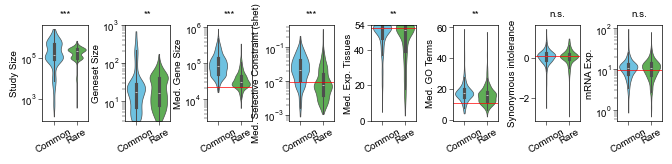

In [97]:
ax1= plot_r_vs_c_violin2(all_rc_initial, paired_res.loc[['N', 'n', 'Length', 'sHet', 'n_mrna','GO','MisSyn', 'mrna']], 
                              labels={**labels, 'N':'Study Size', 'n': 'Geneset Size'})
ax1[2].hlines(y=bio_df.Length.median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[2].set_ylim(2500, 1.2e6)
ax1[1].set_ylim(3, 1000)
ax1[3].hlines(y=coding_df.sHet.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[4].hlines(y=coding_df.n_mrna.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[5].hlines(y=coding_df.GO.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[6].hlines(y=coding_df.MisSyn.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[7].hlines(y=coding_df.mrna.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')

for ax in ax1:
    ax.set_xlim(-0.5, 1.5)

_ = ax1[4].set_yticks([0, 20, 40, 54])
ax1[4].set_ylim(0, 54)

## SFigure 1A

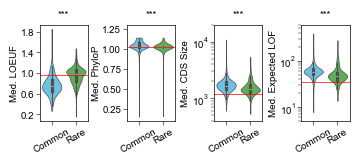

In [98]:
ax1= plot_r_vs_c_violin2(all_rc_initial, paired_res.loc[['pli', 'phy', 'CDS', 'lof']], 
                              labels={**labels, 'N':'Study Size', 'n': 'Geneset Size'})

ax1[2].set_ylim(400, 20000)
ax1[3].set_ylim(5, 600)
ax1[1].set_ylim(0.1, 1.3)
ax1[0].hlines(y=coding_df.pli.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[1].hlines(y=coding_df.phy.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[2].hlines(y=coding_df.CDS.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')
ax1[3].hlines(y=coding_df.lof.dropna().median(), xmin=-0.5, xmax=1.5, linewidth=0.5, color='red')

for ax in ax1:
    ax.set_xlim(-0.5, 1.5)
    
_ = ax1[0].set_yticks([0.2,0.6,1, 1.4,1.8])
_ = ax1[1].set_yticks([0.25, 0.5, 0.75, 1.0, 1.25])


## CV & RV Overlaps

Extract the overlap statistics for the initial study pairs

In [255]:
top_over_df = overlap_df[overlap_df.trait_pair.isin(pairs)].drop_duplicates()
top_over_df['J'] = top_over_df.nShared / (top_over_df.nRare + top_over_df.nCommon - top_over_df.nShared)

In [256]:
top_over_df['q'] = fdrcorrection(top_over_df.pShared.values)[1]
top_over_df['EFO'] = top_over_df.trait_pair.apply(lambda x: map_trait_code(x))

In [271]:
print('Trait with highest CV-RV similarity:')
print(top_over_df.sort_values('J', ascending=False).iloc[0].loc[['EFO', 'nRare', 'nCommon', 'nShared', 'q']])
print('q=', top_over_df.sort_values('J', ascending=False).iloc[0].loc[['EFO', 'nRare', 'nCommon', 'nShared', 'q']].q)

Trait with highest CV-RV similarity:
EFO        EFO_0007805
nRare               17
nCommon             22
nShared             11
q                  0.0
Name: 1019, dtype: object
q= 2.231071984992385e-28


In [259]:
print('Traits with no shared genes:', len(top_over_df[top_over_df.nShared==0]))
print('Traits with significant number of shared genes:', len(top_over_df[(top_over_df.nShared>0) & (top_over_df.q <0.05)]))

Traits with no shared genes: 189
Traits with significant number of shared genes: 179


In [272]:
# Calculate the bars
top_over_df['rare_only'] = top_over_df.nRare - top_over_df.nShared
top_over_df['common_only'] = top_over_df.nCommon - top_over_df.nShared
top_over_df['total'] = top_over_df.rare_only + top_over_df.common_only + top_over_df.nShared
top_over_df['overlap+rare'] = top_over_df.nShared + top_over_df.rare_only
top_over_df = top_over_df.sort_values(by=['nShared', 'total'], ascending=False)

In [261]:
top_over_df['logq'] = top_over_df.q.apply(lambda x: -1 * np.log10(x+1e-50))

In [262]:
plot_df=top_over_df[((top_over_df.total > 100) ) & (top_over_df.total < 1000)].melt(id_vars=['trait_pair', 'q', 'logq'], value_vars=['nShared', 'overlap+rare', 'total'])
total_order = top_over_df.sort_values(by=['nShared', 'nRare', 'nCommon'], ascending=[False, False, False]).trait_pair.values

### Figure 1F

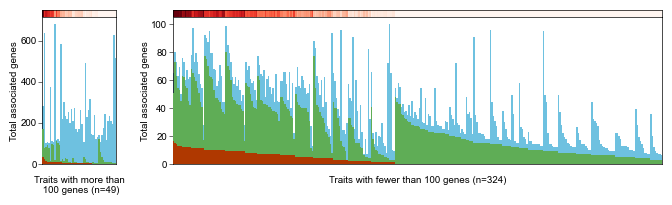

In [265]:
_, [[ax1a, ax2a], [ax1, ax2]] = plt.subplots(2, 2, figsize=(8, 2), sharex=False, 
                                             gridspec_kw={'height_ratios': [1, 20], 'width_ratios':[49,324], 'hspace': 0})

order = [x for x in total_order if x in plot_df.trait_pair.values]
n1=len(order)
sns.heatmap(np.array(plot_df[plot_df.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T,
            ax=ax1a, cbar=False, cmap='Reds', yticklabels=False, xticklabels=False,vmax=25, vmin=0)

sns.barplot(plot_df[plot_df.variable=='nShared'], x='trait_pair', y='value', color='#af3800', zorder=10, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', zorder=5, order=order,
            saturation=1,  ax=ax1, alpha=1, width=1)
sns.barplot(plot_df[plot_df.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', zorder=1, order=order, 
            saturation=1, ax=ax1, alpha=1, width=1)
ax1.set_xticks([])


plot_df2 =top_over_df[ (top_over_df.total <= 100)].melt(id_vars=['trait_pair', 'q','logq'], 
                                                                  value_vars=['nShared', 'overlap+rare', 'total'])
order = [x for x in total_order if x in plot_df2.trait_pair.values]


n2=len(order)
sns.heatmap(np.array(plot_df2[plot_df2.variable=='total'].set_index('trait_pair').loc[order]['logq']).reshape(-1, 1).T, 
            ax=ax2a, cbar=False, 
            cmap='Reds', yticklabels=False, xticklabels=False, vmax=25, vmin=0)

sns.barplot(plot_df2[plot_df2.variable=='nShared'], x='trait_pair', y='value', color='#af3800', 
            zorder=10, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='overlap+rare'], x='trait_pair', y='value', color='#5fad56', 
            zorder=5, order=order, ax=ax2, alpha=1, saturation=1, width=1,)
sns.barplot(plot_df2[plot_df2.variable=='total'], x='trait_pair', y='value', color='#6ec1e0', 
            zorder=1, order=order, ax=ax2, alpha=1, saturation=1, width=1)
ax2.set_xticks([])
ax1.set_xlabel(f'\nTraits with more than\n 100 genes (n={n1})')
ax2.set_xlabel(f'\nTraits with fewer than 100 genes (n={n2})')
_ = ax1.set_ylabel('Total associated genes')
_ = ax2.set_ylabel('Total associated genes')

for ax in [ax1a, ax2a]:
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        

In [266]:
top_over_df_sig = top_over_df[(top_over_df.q<0.05) & (top_over_df.nShared>0)]

In [267]:
print('Median percent of CVGs shared:', f'{100*(top_over_df_sig["nShared"]/top_over_df_sig["nCommon"]).median():.1f}%')

Median percent of CVGs shared: 28.0%


In [268]:
print('Median percent of RVGs shared:', f'{100*(top_over_df_sig["nShared"]/top_over_df_sig["nRare"]).median():.1f}%')

Median percent of RVGs shared: 18.4%
